In [7]:
import sys
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
import pymc as pm
import pytensor
import pytensor.tensor as pt
from matplotlib import cm

sys.path.insert(1, '/Users/andrewroberts/Desktop/git-repos/gp-calibration/python')
from helper_functions import get_bounds, scale_inputs, gen_extrapolation_test_inputs
from vsem import *

In [2]:
RANDOM_SEED = 10
rng = np.random.default_rng(RANDOM_SEED)

In [3]:
# Setup. 

# Number of time steps (days) to simulate model. 
n_year = 3
n_time_step = 365*n_year

# Parameters to calibrate. 
par_cal_names = ["KEXT", "Cr"]

## Latex macros

$$
\newcommand{\state}{x}
\newcommand{\Time}{t}
\newcommand{\timeIdx}{k}
\newcommand{\indexTime}[2][\timeIdx]{{#2}_{#1}}
\newcommand{\firstTimeIdxState}{0}
\newcommand{\firstTimeIdxObs}{1}
\newcommand{\timeInitState}{\indexTime[\firstTimeIdxState]{\Time}}
\newcommand{\timeInitObs}{\indexTime[\firstTimeIdxObs]{\Time}}
\newcommand{\stateInit}{\state_{\firstTimeIdxState}}
\newcommand{\stateInitObs}{\state_{\firstTimeIdxObs}}
\newcommand{\stateApprox}{\hat{\state}}
\newcommand{\timeEnd}{T}
\newcommand{\Ntime}{K} % Number of time steps 
\newcommand{\lastTimeIdx}{\Ntime} % May or may not be equal to \Ntime depending on whether indexing starts from one or zero, etc. 
\newcommand{\timeStep}{h}
\newcommand{\funcODE}{f}
\newcommand{\forcing}{w}
\newcommand{\stateTime}[1][\timeIdx]{\indexTime[{#1}]{\state}}
\newcommand{\forcingTime}[1][\timeIdx]{\indexTime[{#1}]{\forcing}}
\newcommand{\fwdOne}{g} % One-step forward operator (flow map) 
\newcommand{\dimState}{P}
\newcommand{\stateIdx}{p}
\newcommand{\indexState}[2][\stateIdx]{{#2}^{(#1)}}
\newcommand{\stateV}{\state_{\text{v}}}
\newcommand{\stateR}{\state_{\text{r}}}
\newcommand{\stateS}{\state_{\text{s}}}
\newcommand{\dstateV}{\dot{\state}_{\text{v}}}
\newcommand{\dstateR}{\dot{\state}_{\text{r}}}
\newcommand{\dstateS}{\dot{\state}_{\text{s}}}
\newcommand{\NPP}{\textrm{NPP}}
\newcommand{\GPP}{\textrm{GPP}}
\newcommand{\alphaV}{\alpha_{\text{v}}}
\newcommand{\tauV}{\tau_{\text{v}}}
\newcommand{\tauR}{\tau_{\text{r}}}
\newcommand{\tauS}{\tau_{\text{s}}}
\newcommand{\LUE}{\ell}
\newcommand{\LAR}{r}
\newcommand{\KEXT}{\kappa}
\newcommand{\fracRespiration}{\gamma}
\newcommand{\LAI}{\textrm{LAI}}
$$

# The Very Simple Ecosystem Model (VSEM) 


## State Equations 
$$
\begin{align}
\dstateV(\Time) &= \alphaV \NPP(\stateV(\Time), \forcing(\Time)) - \frac{\stateV(\Time)}{\tauV} \\
\dstateR(\Time) &= (1.0 - \alphaV) \NPP(\stateV(\Time), \forcing(\Time)) - \frac{\stateR(\Time)}{\tauR} \nonumber \\ 
\dstateS(\Time) &= \frac{\stateR(\Time)}{\tauR} + \frac{\stateV(\Time)}{\tauV} - \frac{\stateS(\Time)}{\tauS}
\end{align}
$$

## Model Driver
$$
\begin{align}
\NPP(\stateV, \forcing) &= (1 - \fracRespiration) \GPP(\stateV, \forcing) \\
\GPP(\stateV, \forcing) &= \forcing \cdot \LUE \cdot \left[1 - \exp\left\{-\KEXT \cdot \LAI(\stateV) \right\} \right] \\
\LAI(\stateV) &= \LAR \cdot \stateV.
\end{align} 
$$

In [4]:
# VSEM Defaults.
par_default = get_vsem_default_pars()
print(par_default)
par_default = np.asarray(par_default.value)

   par_name      value
0      KEXT      0.500
1       LAR      1.500
2       LUE      0.002
3     GAMMA      0.400
4      tauV   1440.000
5      tauS  27370.000
6      tauR   1440.000
7        Av      0.500
8        Cv      3.000
9        Cs     15.000
10       Cr      3.000


In [5]:
# Choose Calibration parameters and define priors. 
par_prior = get_vsem_default_priors()
par_cal_idx = np.where(par_prior.par_name.isin(par_cal_names))[0]
par_cal_prior = np.take(par_prior, par_cal_idx, axis=0)
dim_par = len(par_cal_names)
par_cal_prior

,par_name,dist,param1,param2
0,KEXT,Uniform,0.2,1.0
10,Cr,Uniform,0.0,200.0


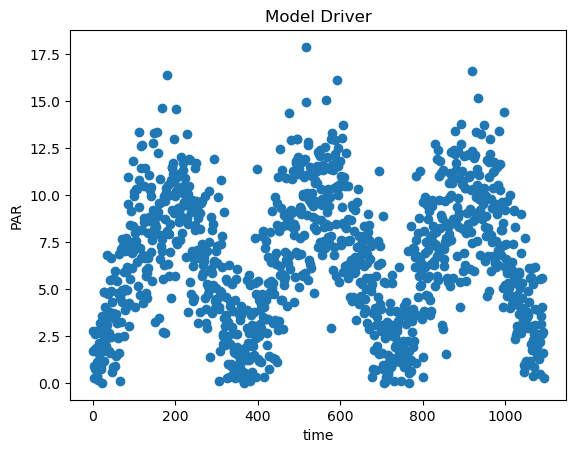

In [6]:
# Forcing/driving data: photosynthetically active radiation. 
# Note that time t here is in days, so t=1 is 1 day and t=365 is 1 year. 
time_steps, model_driver = get_PAR_driver(n_time_step, rng=rng)
plt.plot(time_steps, model_driver, "o")
plt.xlabel("time")
plt.ylabel("PAR")
plt.title("Model Driver")
plt.show()

In [14]:
# Define the observation operator. For convenience, this is broken down in to the 
# composition of a deterministic component and a noise component, but a more complex
# noise model could also be considered. The input to these functions will be the output
# from the function `fwd()` defined above. This will typically be a matrix of shape 
# (number time steps, number output variables).

# def obs_op_annual_mean(fwd_model_output):
#    # This creates annual averages; only works if the number of rows in 
#    # `fwd_model_output` is divisible by 365. 
#    veg_idx = output_names.index("Cv")
#    fwd_model_output = fwd_model_output[:,veg_idx,np.newaxis]
#    n_output = fwd_model_output.shape[1]
#    return fwd_model_output.reshape((-1,365,n_output)).mean(axis=1)

output_names = get_vsem_output_names()
veg_idx = output_names.index("Cv")

def obs_op(fwd):
    return fwd[:,veg_idx,np.newaxis]

def param_to_obs_op(par):
    return obs_op(fwd(par))    

In [20]:
# Generate ground truth data and observed data.
signal_to_noise_ratio = 10
par_true = par_default
fwd_true = fwd_vsem(par_true, model_driver)
y_true = obs_op(fwd_true)
sig_eps =  np.mean(y_true) / signal_to_noise_ratio
eps = sp.stats.norm(loc=0, scale=np.sqrt(sig_eps))
y = y_true + eps.rvs(size=y_true.shape, random_state=rng)

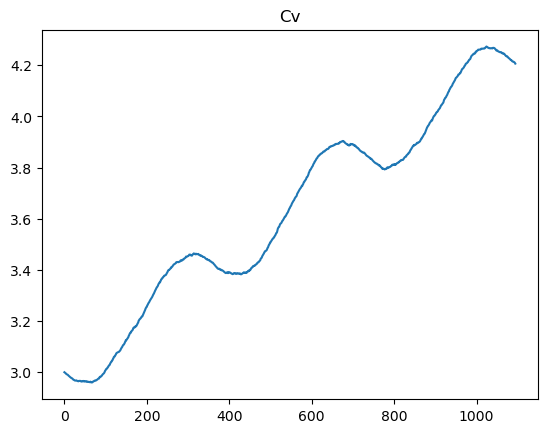

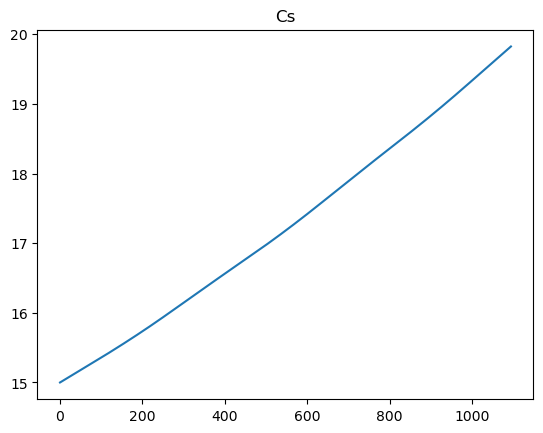

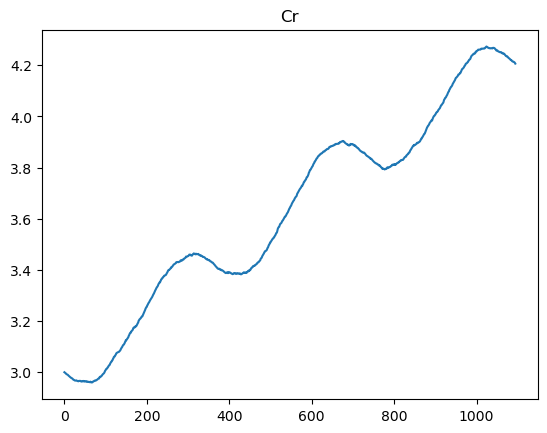

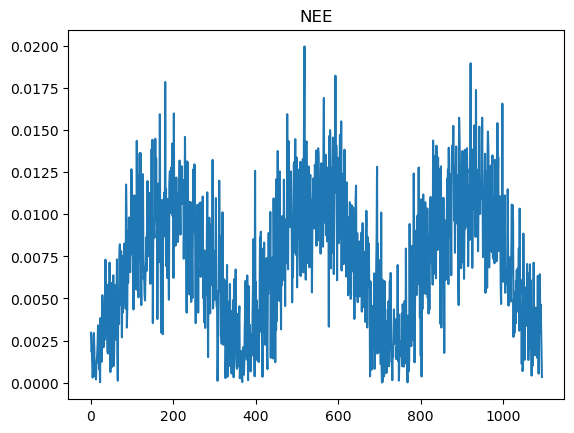

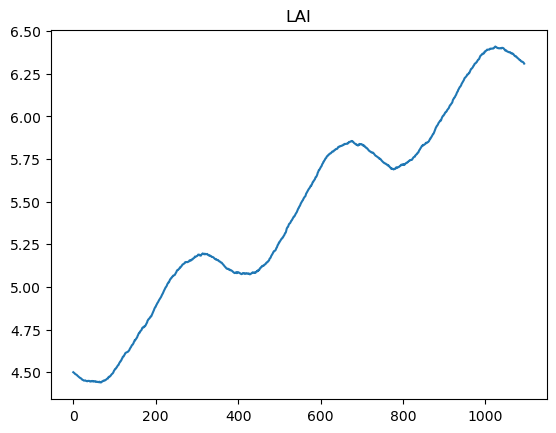

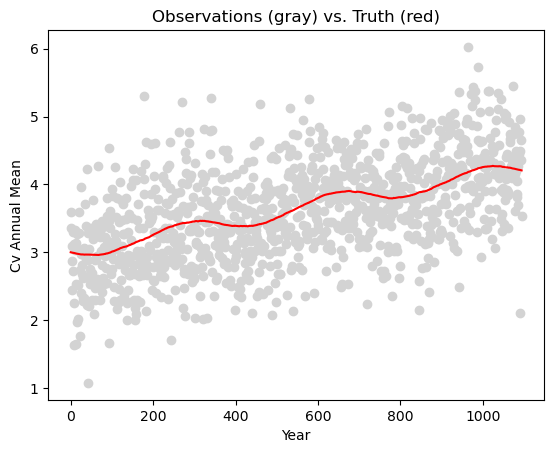

In [23]:
# Model Projections. 
for j in range(fwd_true.shape[1]):
    plt.plot(time_steps, fwd_true[:,j])
    plt.title(output_names[j])
    plt.show()

# Observations.
plt.plot(time_steps, y, marker="o", linestyle="", color="lightgray")
plt.plot(time_steps, y_true, color="red")
plt.title("Observations (gray) vs. Truth (red)")
plt.xlabel("Year")
plt.ylabel("Cv Annual Mean")
plt.show()

# Log Prior, Exact Likelihood, and Posterior Density Functions

In [28]:
par_cal_prior["param1"].values

array([0.2, 0. ])

In [29]:
prior = []
for i in range(dim_par):
    loc = par_cal_prior.param1.values[i]
    scale = par_cal_prior.param2.values[i] - loc
    prior.append(sp.stats.uniform(loc=loc, scale=scale))

In [30]:
def llik(par):
    y = param_to_obs_op(par)
    return eps.logpdf(y-fwd(par)).sum()

def lprior(par):
    return np.sum([prior[i].logpdf(par[i]) for i in range(dim_par)])

def lpost(par): 
    return llik(par) + lprior(par)

# Design and Test Points 

In [33]:
# Generate design points based on prior distribution. 
n_design = 10
lh_sampler = sp.stats.qmc.LatinHypercube(d=dim_par)
uniform_design = lh_sampler.random(n=n_design)
par_cal_design = np.hstack((prior[0].ppf(uniform_design[:,0]).reshape((n_design,1)), 
                            prior[1].ppf(uniform_design[:,1]).reshape((n_design,1))))

In [34]:
test = fwd_vsem(par_cal_design, model_driver, par_cal_idx, par_default)

In [35]:
test.shape

(10, 1095, 5)

In [37]:
test[:,:,0,np.newaxis].shape

(10, 1095, 1)

In [15]:
# Generate llik responses at design points. 
y_design = np.empty(n_design)
for i in range(n_design):
    y_design[i] = llik(X_design[i,:])

In [22]:
# Generate grid of test points. 
n_grid_1d = 50
grid_bounds = np.asarray(np.take(par_priors, par_cal_idx, axis=0)[["param1", "param2"]]).T
x1_grid = np.linspace(grid_bounds[0,0], grid_bounds[1,0], num=n_grid_1d)
x2_grid = np.linspace(grid_bounds[0,1], grid_bounds[1,1], num=n_grid_1d)
x_grid = np.meshgrid(x1_grid, x2_grid)
X_test = np.array([(x1, x2) for x1 in x1_grid for x2 in x2_grid])

In [ ]:
# Generate llik responses at test points. 
n_test = X_test.shape[0]
y_test = np.empty(n_test)

for i in range(n_test):
    y_test[i] = llik(X_test[i,:])

In [63]:
# Save to file. 

df_test = pd.DataFrame(data=np.hstack((X_test, y_test.reshape((n_test,1)))))
df_test.columns = ["x1", "x2", "y"]
df_test.to_csv("test_points.csv")

In [16]:
df_test = pd.read_csv("test_points.csv")

In [19]:
X_test = np.asarray(df_test[["x1", "x2"]])
y_test = np.asarray(df_test.y)

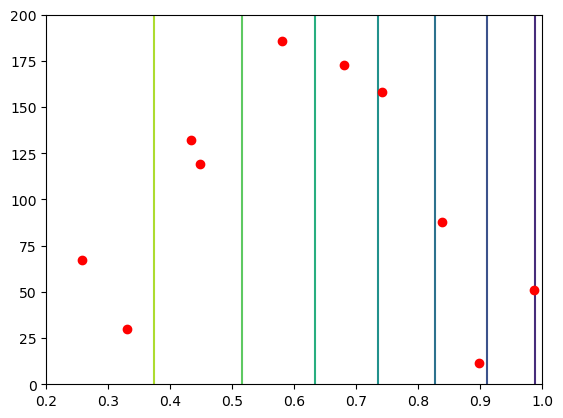

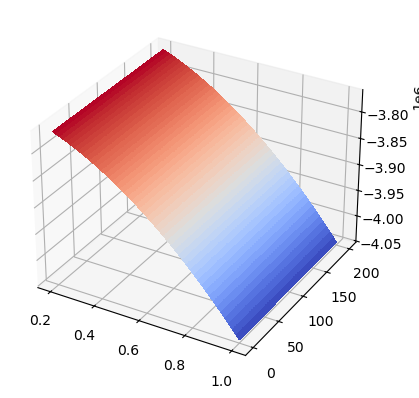

In [27]:
# Contour plot. 
plt.contour(x_grid[0], x_grid[1], y_test.reshape(n_grid_1d, n_grid_1d))
plt.plot(X_design[:,0], X_design[:,1], "or")
plt.show()

# Contour plot with extrapolation points. 
# plt.contour(x_grid[0], x_grid[1], y.reshape(n_grid_1d, n_grid_1d))
# plt.plot(X_design[:,0], X_design[:,1], "or")
# plt.plot(X_extrap_long[:,0], X_extrap_long[:,1], "og")
# plt.show()

# 3d surface plot. 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X=x_grid[0], Y=x_grid[1], Z=y_test.reshape(n_grid_1d, n_grid_1d), cmap=cm.coolwarm, linewidth=0, antialiased=False)
plt.show()

In [32]:
tester = rng.normal(size=(5,4))

In [35]:
tester[:,:3]

array([[ 0.00746173, -0.24950555, -0.49050754],
       [-1.12827885, -0.58535462,  0.1732808 ],
       [ 1.23706917,  0.14716541, -0.07809968],
       [-0.11378223, -1.22542447,  2.0923337 ],
       [-0.1340264 ,  0.52687606,  0.14216634]])